This notebook examines how to create a new fit_template for EIS data.
Here the focus will be the S VIII 198.55 line.

### The fit template

The line fitting in eispac is typically perfomed by providing a fit_template, which contains information about the fitting parameters (e.g. initial guesses, constrains, etc.). 

eispac contains a number of fit_templates for different lines, but not all lines have already a fit template. One such example is the S VIII 198.55 line.

The fit_templates are hdf5 files and they contain two main Groups, the 'template' and the 'parinfo'. These can be examined by looking at an existing template, like the one for Si VII 275.368.

In [12]:
import h5py

template_filename = 'si_07_275_368.1c.template.h5'
tmplt_dir = './Data/fit_templates'
template_filepath = tmplt_dir + '/' + template_filename
tmplt = eispac.read_template(template_filepath)


In [13]:
tmplt.parinfo

[{'fixed': 0,
  'limited': array([1, 0], dtype=int16),
  'limits': array([0., 0.]),
  'tied': array('', dtype='<U1'),
  'value': 2160.9863786158053},
 {'fixed': 0,
  'limited': array([1, 1], dtype=int16),
  'limits': array([275.32501398, 275.40529399]),
  'tied': array('', dtype='<U1'),
  'value': 275.3651539835592},
 {'fixed': 0,
  'limited': array([1, 1], dtype=int16),
  'limits': array([0.01910828, 0.05095541]),
  'tied': array('', dtype='<U1'),
  'value': 0.030653187366725062},
 {'fixed': 0,
  'limited': array([0, 0], dtype=int16),
  'limits': array([0., 0.]),
  'tied': array('', dtype='<U1'),
  'value': 36.302617504735665}]

In [14]:
tmplt.template

{'component': 1,
 'data_e': array([12.448081 , 11.079003 , 11.117625 , 12.303108 , 12.9370985,
        20.168133 , 31.033236 , 43.15835  , 49.15887  , 41.41116  ,
        28.831747 , 19.490063 ], dtype=float32),
 'data_x': array([275.18903, 275.21124, 275.23352, 275.25574, 275.278  , 275.30023,
        275.32245, 275.34473, 275.36694, 275.38922, 275.41144, 275.43365],
       dtype=float32),
 'data_y': array([  58.751583,   19.262491,   21.373722,   55.2766  ,   69.03847 ,
         267.3988  ,  858.55316 , 1732.588   , 2268.4558  , 1584.2301  ,
         711.0475  ,  241.27818 ], dtype=float32),
 'fit': array([2.16098638e+03, 2.75365154e+02, 3.06531874e-02, 3.63026175e+01]),
 'fit_back': 36.302617504735665,
 'fit_gauss': array([2.16098638e+03, 2.75365154e+02, 3.06531874e-02]),
 'line_ids': array(['Si VII 275.368'], dtype='<U14'),
 'n_gauss': 1,
 'n_poly': 1,
 'order': 1,
 'wmax': 275.45,
 'wmin': 275.168}

Based on the above I will try to create my own template for another line.
First fitting the data and then creating the 'template' and the 'parinfo'.

### Fitting the data 

In [1]:
import scipy.io as io
import eispac
import numpy as np 
import os 
import matplotlib.pyplot as plt


Data file,
   /home/alexandros/Dev/EIS_data_analysis/Data/eis_20110525_235841.data.h5
Header file,
   /home/alexandros/Dev/EIS_data_analysis/Data/eis_20110525_235841.head.h5
Found a wavelength 198.55 [Angstroms] in window 7
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


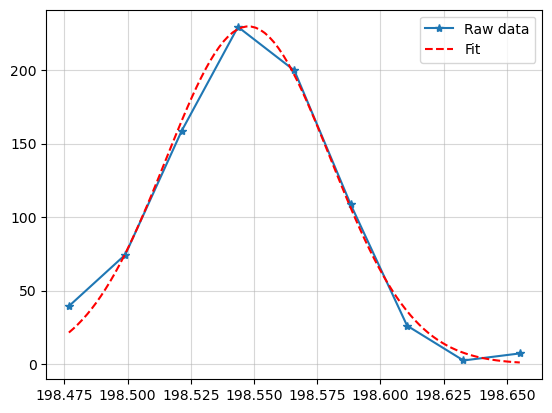

In [16]:
## Method 1 
# Use the astropy library and the LevMar method
from astropy import modeling

# Load the data 
data_dir = './Data'
data_name = 'eis_20110525_235841.data.h5'
data_filepath = os.path.join(data_dir,data_name)
data_cube = eispac.read_cube(data_filepath,198.550) #S VIII 

# Select a pixel
ix = 20#35#30#20
iy = 30#150#100#30 

# wvl = data_cube.wavelength[iy,ix,:]
# rawdata = data_cube.data[iy,ix,:]
# data_err = data_cube.uncertainty.array[iy, ix, :]
## Maunally reduce the wavelength extend for fitting
wvl = data_cube.wavelength[iy,ix,:][7:-8]
rawdata = data_cube.data[iy,ix,:][7:-8]
data_err = data_cube.uncertainty.array[iy, ix, :][7:-8]

# Initial guesses 
amp_g = max(rawdata)
mean_g = np.mean(rawdata)
std_g = np.std(rawdata)

# Fitting
fitter = modeling.fitting.LevMarLSQFitter()
model = modeling.models.Gaussian1D(amplitude=amp_g,mean=mean_g,stddev=std_g)
fitted_model = fitter(model, wvl, rawdata)

# Plotting
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(wvl,rawdata,'*-',label='Raw data')
wvl_arr = np.linspace(min(wvl),max(wvl),100)
ax.plot(wvl_arr,fitted_model(wvl_arr),'r--',label='Fit')
ax.grid(alpha=0.5)
ax.legend()

### Create new template

The __template__ is a dictionairy and the __parinfo__ a list of dictionairies, from [here](https://github.com/USNavalResearchLaboratory/eispac/blob/7a480262aac6a45188f5c88865f1909424556d03/eispac/core/read_template.py#L10)

In [17]:
## My template
model_params = fitted_model.parameters
# print(fitted_model.param_names)
background = 30. #manual selection for the time being  
my_fit = np.append(model_params,background)
fit_line_list = ['S VIII 198.55']
my_tmplt = {'component':1,
            'data_e': data_err,
            'data_x': wvl,
            'data_y': rawdata,
            'fit': my_fit,
            'fit_back': my_fit[-1],
            'fit_gauss': my_fit[0:-1],
            'line_ids': fit_line_list,
            'n_gauss':1,
            'n_poly':1,
            'order':1,
            'wmax':198.83,
            'wmin':198.32
            }


## My parinfo
# I take the 'tied' from an existing template
ff = h5py.File(template_filepath,'a')
tied = ff['parinfo/tied'][()]
ff.close()

my_parinfo = {'fixed':np.array([0,0,0,0]),
               'limited':np.array([[1,0],[1,1],[1,1],[0,0]]),
              # 'limited':np.array([[0,0],[0,0],[0,0],[0,0]]),
              # 'limits':np.array([[0.,0.],[0.,0.],[0.,0.],[0.,0.]]),
              'limits':np.array([[0.,0.],[198.43,198.63],
                                 [1.91082805e-02, 5.09554148e-02],[0.,0.]]),
              'tied':tied,    # Take it from an existing template
              'value':my_fit}

#!!! Needs to be a list of dictionairies
# my_parinfo2 = []  
# for k in my_parinfo.keys():
#     my_parinfo2.append({k:my_parinfo[k]})
# my_parinfo2.append({'fixed':np.array([0,0,0,0])})

my_parinfo3 = [] 
# Get the dictionairy keys
kk = []
for k in my_parinfo.keys():
    kk.append(k)
# Create the list of dictionairies
for i in range(4):
    tmp_dict = {kk[0]:my_parinfo[kk[0]][i],kk[1]:my_parinfo[kk[1]][i],
                kk[2]:my_parinfo[kk[2]][i],kk[3]:my_parinfo[kk[3]][i],
                kk[4]:my_parinfo[kk[4]][i]}
    my_parinfo3.append(tmp_dict)



In [22]:
my_template = 'my_S_VIII_fit_template.h5'
my_SVIII_fit_tmplt = eispac.EISFitTemplate(my_template,my_tmplt,my_parinfo3)

Let's see how it looks like:


In [23]:
my_SVIII_fit_tmplt.central_wave

198.575

In [24]:
my_SVIII_fit_tmplt.template

{'component': 1,
 'data_e': array([16.60194662, 22.30937926, 32.14847698, 38.57738121, 36.12010351,
        26.92600516, 14.0415298 ,  6.71308329,  8.7421856 ]),
 'data_x': array([198.47682915, 198.49910948, 198.5213898 , 198.54367009,
        198.56595035, 198.58823058, 198.6105108 , 198.63279098,
        198.65507114]),
 'data_y': array([ 39.35307 ,  74.35634 , 158.61224 , 229.47478 , 199.81613 ,
        108.56598 ,  26.066013,   2.379302,   7.167375], dtype=float32),
 'fit': array([2.29822352e+02, 1.98547791e+02, 3.25591093e-02, 3.00000000e+01]),
 'fit_back': 30.0,
 'fit_gauss': array([2.29822352e+02, 1.98547791e+02, 3.25591093e-02]),
 'line_ids': ['S VIII 198.55'],
 'n_gauss': 1,
 'n_poly': 1,
 'order': 1,
 'wmax': 198.83,
 'wmin': 198.32}

In [25]:
my_SVIII_fit_tmplt.parinfo

[{'fixed': 0,
  'limited': array([1, 0]),
  'limits': array([0., 0.]),
  'tied': b'',
  'value': 229.82235172429023},
 {'fixed': 0,
  'limited': array([1, 1]),
  'limits': array([198.43, 198.63]),
  'tied': b'',
  'value': 198.54779101731447},
 {'fixed': 0,
  'limited': array([1, 1]),
  'limits': array([0.01910828, 0.05095541]),
  'tied': b'',
  'value': 0.03255910934239916},
 {'fixed': 0,
  'limited': array([0, 0]),
  'limits': array([0., 0.]),
  'tied': b'',
  'value': 30.0}]

### Fit with the new template

In [26]:
# if __name__ == '__main__':

data_cube = eispac.read_cube(data_filepath, my_SVIII_fit_tmplt.central_wave,apply_radcal=True) 

## Fit the data, then save it to disk
save_dir = data_dir + '/fit_res'
fit_res = eispac.fit_spectra(data_cube, my_SVIII_fit_tmplt, ncpu='max')
save_filepaths = eispac.save_fit(fit_res, save_dir=save_dir)


Data file,
   /home/alexandros/Dev/EIS_data_analysis/Data/eis_20110525_235841.data.h5
Header file,
   /home/alexandros/Dev/EIS_data_analysis/Data/eis_20110525_235841.head.h5
Found a wavelength 198.57 [Angstroms] in window 7
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
 + computing fits for 60 exposures, each with 512 spectra
 + running mpfit on 6 cores (of 6)
 + working on exposure 013 + working on exposure 004 + working on exposure 007 ! fit did not converge! ! fit did not converge!
 + working on exposure 016 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!



 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!




 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge! !

 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!




 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge! ! fit did not converge! !

 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!



 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 !

 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!



 ! fit did not converge!

 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge!



 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!



 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 !

 ! fit did not converge!


 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!



 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!





 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!



 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!



 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! 

 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!




 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!




 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!



 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!



 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!



 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 

 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!



 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!
 !

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!





 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!



 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 !

 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!




 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!



 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!

 

 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!



 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! 

 ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!





 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!




 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!




 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!



 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge! !

 ! fit did not converge! ! fit did not converge! ! fit did not converge!




 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!




 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!



 ! fit did not converge! ! fit did not converge! ! fit did not converge!



 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!




 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! 

 ! fit did not converge! ! fit did not converge! ! fit did not converge!




 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!




 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!



 ! fit did not converge! ! fit did not converge! ! fit did not converge!



 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!




 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge!

 ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 

 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!




 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!



 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge!



 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! 

 ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!



 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!
 + working on exposure 003

 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge!


 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!


 ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!





 ! fit did not converge! ! fit did not converge

 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!

 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!



 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!





 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!



 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! 

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!



 ! fit did not converge

 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 !

 ! fit did not converge! ! fit did not converge!



 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!




 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!



 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!



 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!



 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!



 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!



 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!



 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!






 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!



 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!



 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!



 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge!


 ! fit did not converge! 

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!



 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!



 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!



 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge!


 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge!

 ! fit did not converge!

 ! fit did not converge!


 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!



 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!



 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!



 ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!



 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!

 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!





 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!





 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!



 ! fit did not converge! 

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!




 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!



 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!





 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 

 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!



 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!



 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!



 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge!


 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! !

 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge!


 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!




 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!



 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!



 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge! 

 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! 

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!



 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!



 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!


 

 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!




 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!




 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!



 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!




 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!




 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!
 

 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!



 ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!



 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! !

 ! fit did not converge! ! fit did not converge! + working on exposure 030 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!



 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!



 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!




 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!




 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge!


 ! fit did not converge! ! fit did not converge! !

 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!





 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge!

 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!



 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge!
 

 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!


 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!



 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! !

 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!




 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!




 ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!




 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!





 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 !

 ! fit did not converge!




 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!



 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!



 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!


 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!



 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge!



 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!



 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!

 !

 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!





 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! 

 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!



 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! 

 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!





 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge!



 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!



 ! fit did not converge! ! fit did not converge! ! fit did not converge!



 ! fit did not converge! ! fit did not converge! ! fit did not converge! + working on exposure 027 ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge!

 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge!


 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!



 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!




 ! fit did not converge

 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!



 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!





 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!



 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge!

 ! fit did not converge! 

 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!

 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!



 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge!


 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!



 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!



 ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!



 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!




 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!



 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!



 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!



 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!


 

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!





 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!




 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge!


 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!



 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!



 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!


 ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge! 

 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge!



 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!



 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!



 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!



 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge!



 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!



 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!



 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!



 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! f

 ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!



 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! !

 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!




 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge!


 ! fit did not converge

 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge!



 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!



 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!



 ! fit did not converge! ! fit did not converge! ! fit did not converge! 

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!



 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!




 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!



 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!



 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!




 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!



 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!




 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge! 

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!




 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!



 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!



 ! fit did not converge!


 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!



 ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge!



 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!





 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge!



 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!



 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge!


 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!




 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!




 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!



 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!




 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!



 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!



 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!



 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge!





 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!




 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! 

 ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!





 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!



 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!



 ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!



 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!




 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!



 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge

 ! fit did not converge!

 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!



 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!




 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!




 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!



 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! f

 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge!


 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!



 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!





 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!


 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge! ! fit did not converge!
 

 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!



 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!




 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!




 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge! !

 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!



 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!




 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!




 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!
 

 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!



 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!



 ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!



 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!



 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! f

 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!





 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!



 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!




 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!



 ! fit did not converge! ! fit did not converge! 

 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!




 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!



 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!




 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge!




 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge!




 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge!



 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!



 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!



 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge!


 ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge! 

 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!



 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!




 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!


 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! 

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!



 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!




 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!



 ! fit did not converge! 

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge!
 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge!



 ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge! ! fit did not converge! ! fit did not converge!

 ! fit did not converge!


 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!


 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! 

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!



 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 + working on exposure 060
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! + working on exposure 057
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge

 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!


 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!



 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge!
 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!

 ! fit did not converge! ! fit did not converge!
 ! fit did not converge!

 ! fit did not converge! 

/home/alexandros/anaconda3/lib/python3.8/site-packages/eispac/core/fit_spectra.py:423: RuntimeWarning: invalid value encountered in divide
  rel_err = obs_errs/obs_cent
